In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import XYZfromAET, AETfromXYZ

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

np.random.seed(114514)
xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## Prepare models 

### orbit

In [2]:
# orbit model 
orbit_file = '/media/ps/One Touch/TDCII_Code/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB'
orbit = Orbit(OrbitDir=orbit_file)

### waveform and response 

In [3]:
mode = "primary" # "primary" or "full"
interp_waveform = True # True if the final TDI responses are interpolated from sparse frequency grid, False if calculated at full frequency grid
use_gpu = True

if mode == "primary":
    modes = [(2,2)]
    approx = "IMRPhenomD"
elif mode == "full": 
    modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
    approx = "IMRPhenomHM"
else: 
    raise NotImplementedError("mode not implemented")

# initialize  waveform generator 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# initialize response generator 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

channel_names = ["A2", "E2", "T2"]

# response settings 
response_kwargs = dict(
    modes=modes, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=interp_waveform,
    interpolate_points=1024, 
)

## Load data 

In [4]:
with open("FDSimulationData.pkl", "rb") as datafile:
    datadict = pickle.load(datafile)
datadict.keys()

dict_keys(['frequency', 'AET', 'parameters', 'metadata'])

In [5]:
tstart = datadict["metadata"]["t_start"]
tend = datadict["metadata"]["t_end"]
data_frequency = xp.array(datadict["frequency"])
delta_f = data_frequency[1] - data_frequency[0]
Tobs = 1. / delta_f
data_channels = xp.array(datadict["AET"])
fiducial_parameters = datadict["parameters"]

response_kwargs["tmin"] = tstart / DAY
response_kwargs["tmax"] = tend / DAY 

response_kwargs, data_frequency.shape, data_channels.shape 

({'modes': [(2, 2)],
  'tc_at_constellation': False,
  'TDIGeneration': '2nd',
  'optimal_combination': True,
  'output_by_mode': False,
  'interpolation': True,
  'interpolate_points': 1024,
  'tmin': 60.0,
  'tmax': 65.0},
 (20736,),
 (3, 20736))

## Model noise 
notice that this is a simplified model and the AET channels are only approximately independent. 

In [6]:
# noise PSD model 
PSDfunc = TDIPSDs()

# use the median time to calculate armlengths
arm_time = (tend + tstart) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm lengths:", arms)

PSD_channels = xp.array([
    PSDfunc.PSD_A2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_E2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_T2_unequal(data_frequency.get(), arms)
])

# covariance matrix 
CovMat = xp.array([
    [PSD_channels[0], xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), PSD_channels[1], xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = xp.linalg.inv(xp.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)

PSD_channels.shape, InvCovMat.shape 

arm lengths: {'12': array(9.9423583), '13': array(9.99401934), '23': array(9.99148366), '21': array(9.94356135), '31': array(9.99487241), '32': array(9.99111644)}


((3, 20736), (20736, 3, 3))

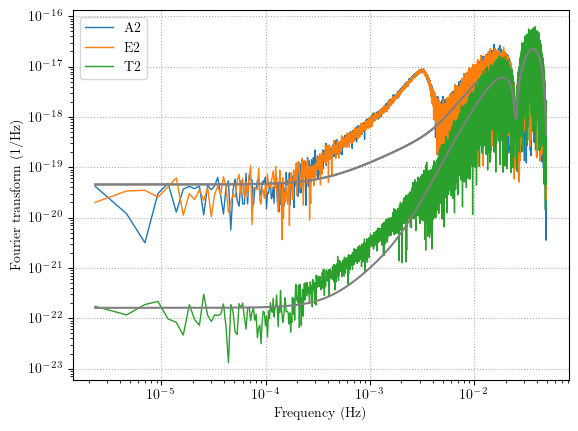

In [7]:
for ich, nch in enumerate(channel_names):
    plt.loglog(data_frequency.get(), np.abs(data_channels[ich].get()), label=nch, linewidth=1)
    plt.loglog(data_frequency.get(), np.sqrt(PSD_channels[ich] / 2. / delta_f).get(), color="grey")

plt.legend(loc="upper left")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform (1/Hz)")
plt.grid(linestyle=":")

## Use A, E channels only 
set $C^{-1}_{T_2 T_2} \equiv 0$ to eliminate the contribution of $T_2$

In [8]:
InvCovMat[:, 2, 2] *= 0. 

## Likelihood

In [9]:
Like = Likelihood(
    response_generator=FDTDI, 
    frequency=data_frequency, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs, 
    use_gpu=use_gpu,
)

number of freuqncies: 20736
min and max frequencies: 2.3148148148148148e-06 0.049
response kwargs: {'modes': [(2, 2)], 'tc_at_constellation': False, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True, 'interpolate_points': 1024, 'tmin': 60.0, 'tmax': 65.0}


## Run MCMC Sampling 
search with the full likelihood from a broad prior 

In [10]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [11]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 200 # number of random walkers, limited by the vRAM of my 4080S, use fewer (e.g. 100) to speed up and more (e.g. 400) to get more smooth posterior 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # mcmc move 

stop = None 

# set priors 
lim_lgMc = [5.5, 6.5]
lim_q = [0.1, 0.999]
lim_chiz1 = [-0.99, 0.99]
lim_chiz2 = [-0.99, 0.99]
lim_tc = [fiducial_parameters["coalescence_time"] - 500/DAY, fiducial_parameters["coalescence_time"] + 500/DAY] # assume a preliminary search step to locate the merger within 1000s
lim_phic = [0, TWOPI]
lim_lgD = [3.5, 5.5]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

lims 

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  0.999     ],
       [-0.99      ,  0.99      ],
       [-0.99      ,  0.99      ],
       [61.99421296, 62.00578704],
       [ 0.        ,  6.28318531],
       [ 3.5       ,  5.5       ],
       [-1.        ,  1.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ],
       [ 0.        ,  3.14159265]])

In [12]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    return Like.full_log_like_vectorized(np.transpose(params))

In [13]:
# init_ensemble = EnsembleSampler(
#     nwalkers,
#     ndim,
#     eryn_like, 
#     priors,
#     args=[],
#     tempering_kwargs=tempering_kwargs,
#     stopping_fn=stop,
#     stopping_iterations=10,
#     moves=mcmc_moves,
#     vectorize=True,
# )

# filename='MCMCResults/FullLogLike.h5'
# backend = HDFBackend(filename)
# backend.reset(nwalkers=nwalkers, ndims=ndim, ntemps=ntemps, moves=init_ensemble.backend.move_keys)
# print('args of the backend =', backend.reset_args)
# print('move keys =', backend.move_keys)
# print('Initialization flag of backend =', backend.initialized)


# ensemble = EnsembleSampler(
#     nwalkers,
#     ndim,
#     eryn_like, 
#     priors,
#     args=[],
#     tempering_kwargs=tempering_kwargs,
#     stopping_fn=stop,
#     stopping_iterations=10,
#     moves=init_ensemble.moves,
#     backend=backend,
#     vectorize=True,
# )


ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [14]:
# randomize starting positions throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 200, 11)


100%|██████████| 100000/100000 [9:27:45<00:00,  2.94it/s] 


In [20]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(100000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

 20%|██        | 20119/100000 [1:55:48<7:37:50,  2.91it/s] 

## Show moves 

In [ ]:
labels = [r"${\rm lg}\mathcal{M}_{c,z}$", r"$q$", r"$\chi_{z,1}$", r"$\chi_{z,2}$", r"$t_c$", r"$\varphi_c$", r"${\rm lg} D_L$", r"$\cos \iota$", r"$\lambda$", r"$\sin \beta$", r"$\psi$"]

truths = ParamDict2ParamArr(fiducial_parameters)

truths

[6.301029995663981,
 0.4719138674211496,
 -0.219017,
 0.777287,
 62.0,
 3.123620213369193,
 4.946800670728753,
 0.7694193036056729,
 4.484587022801057,
 0.7847660639267573,
 2.050979301490759]

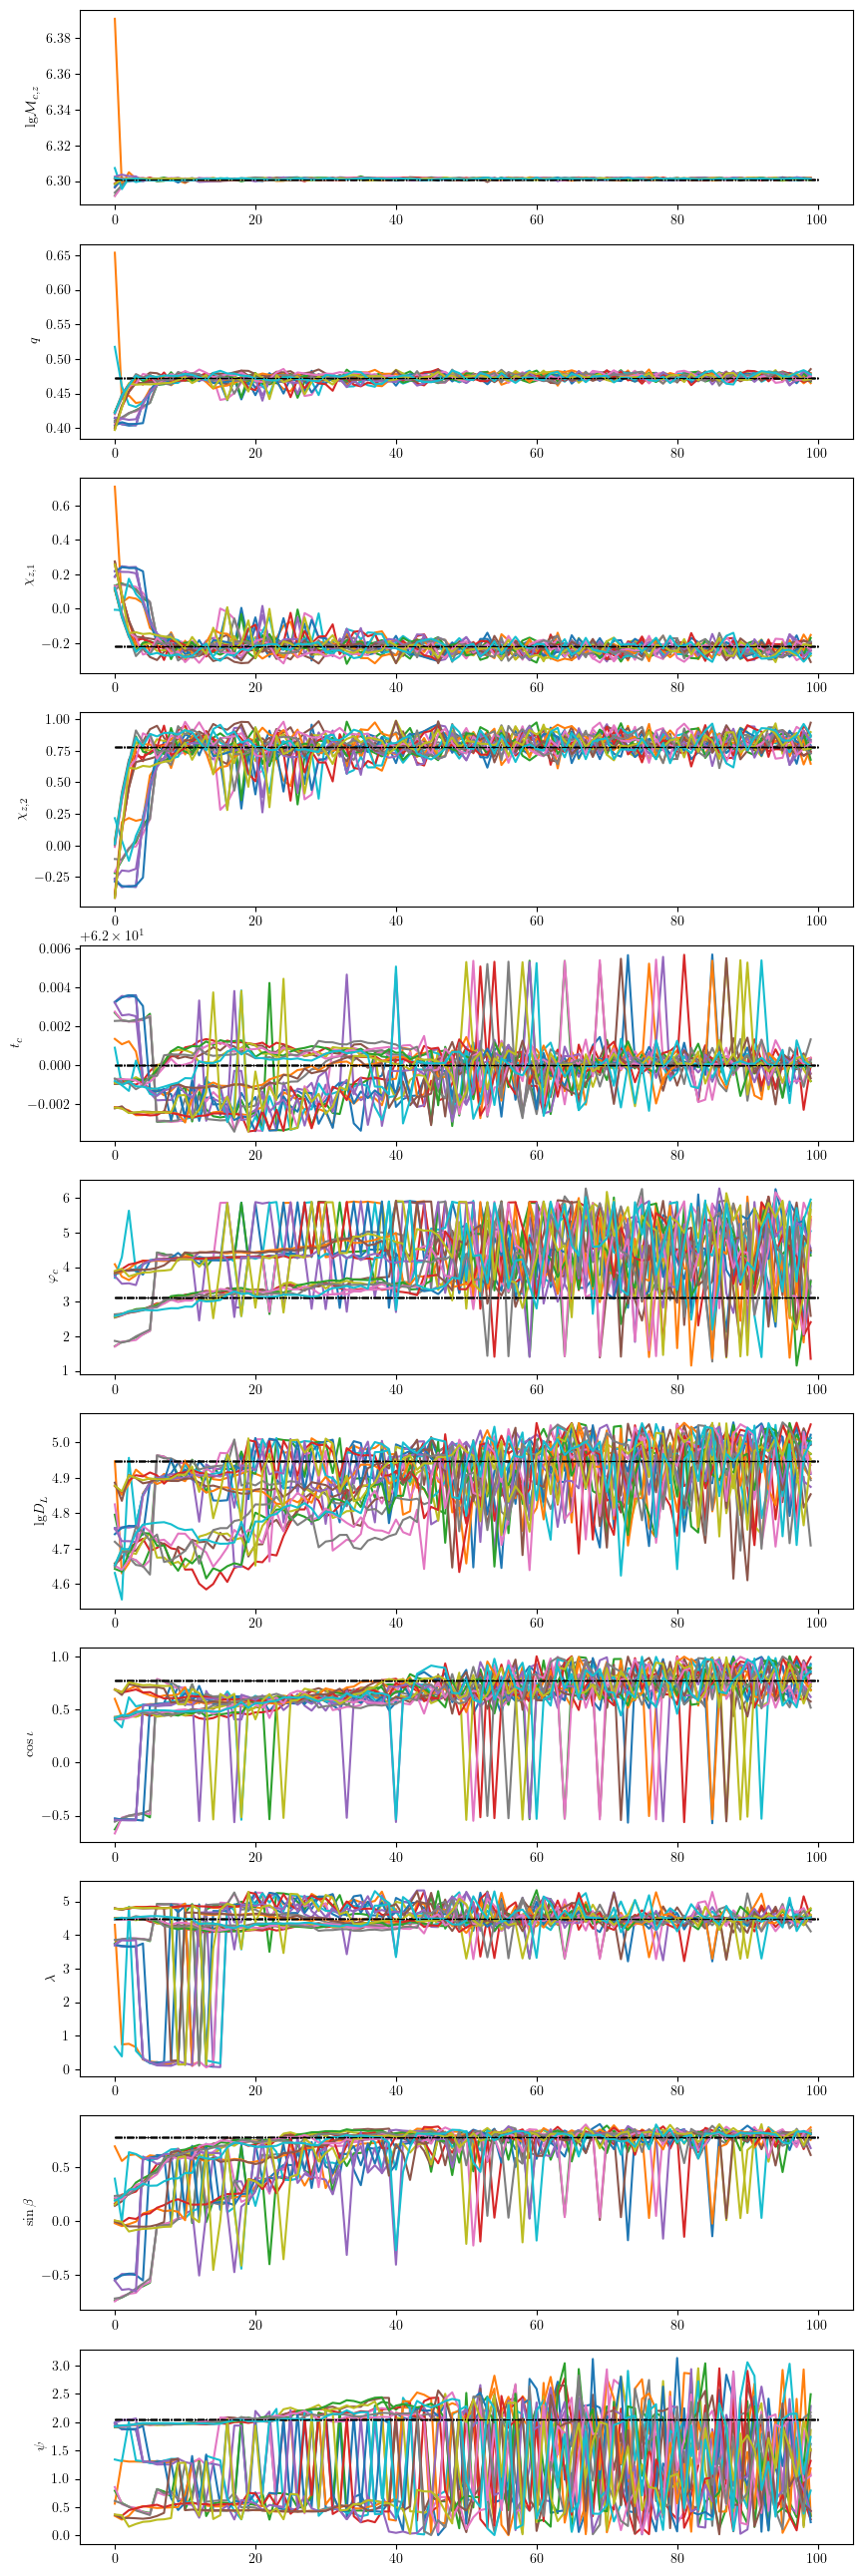

In [ ]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])

## Corner plot

sample shape: (4000, 11)


<Figure size 640x480 with 0 Axes>

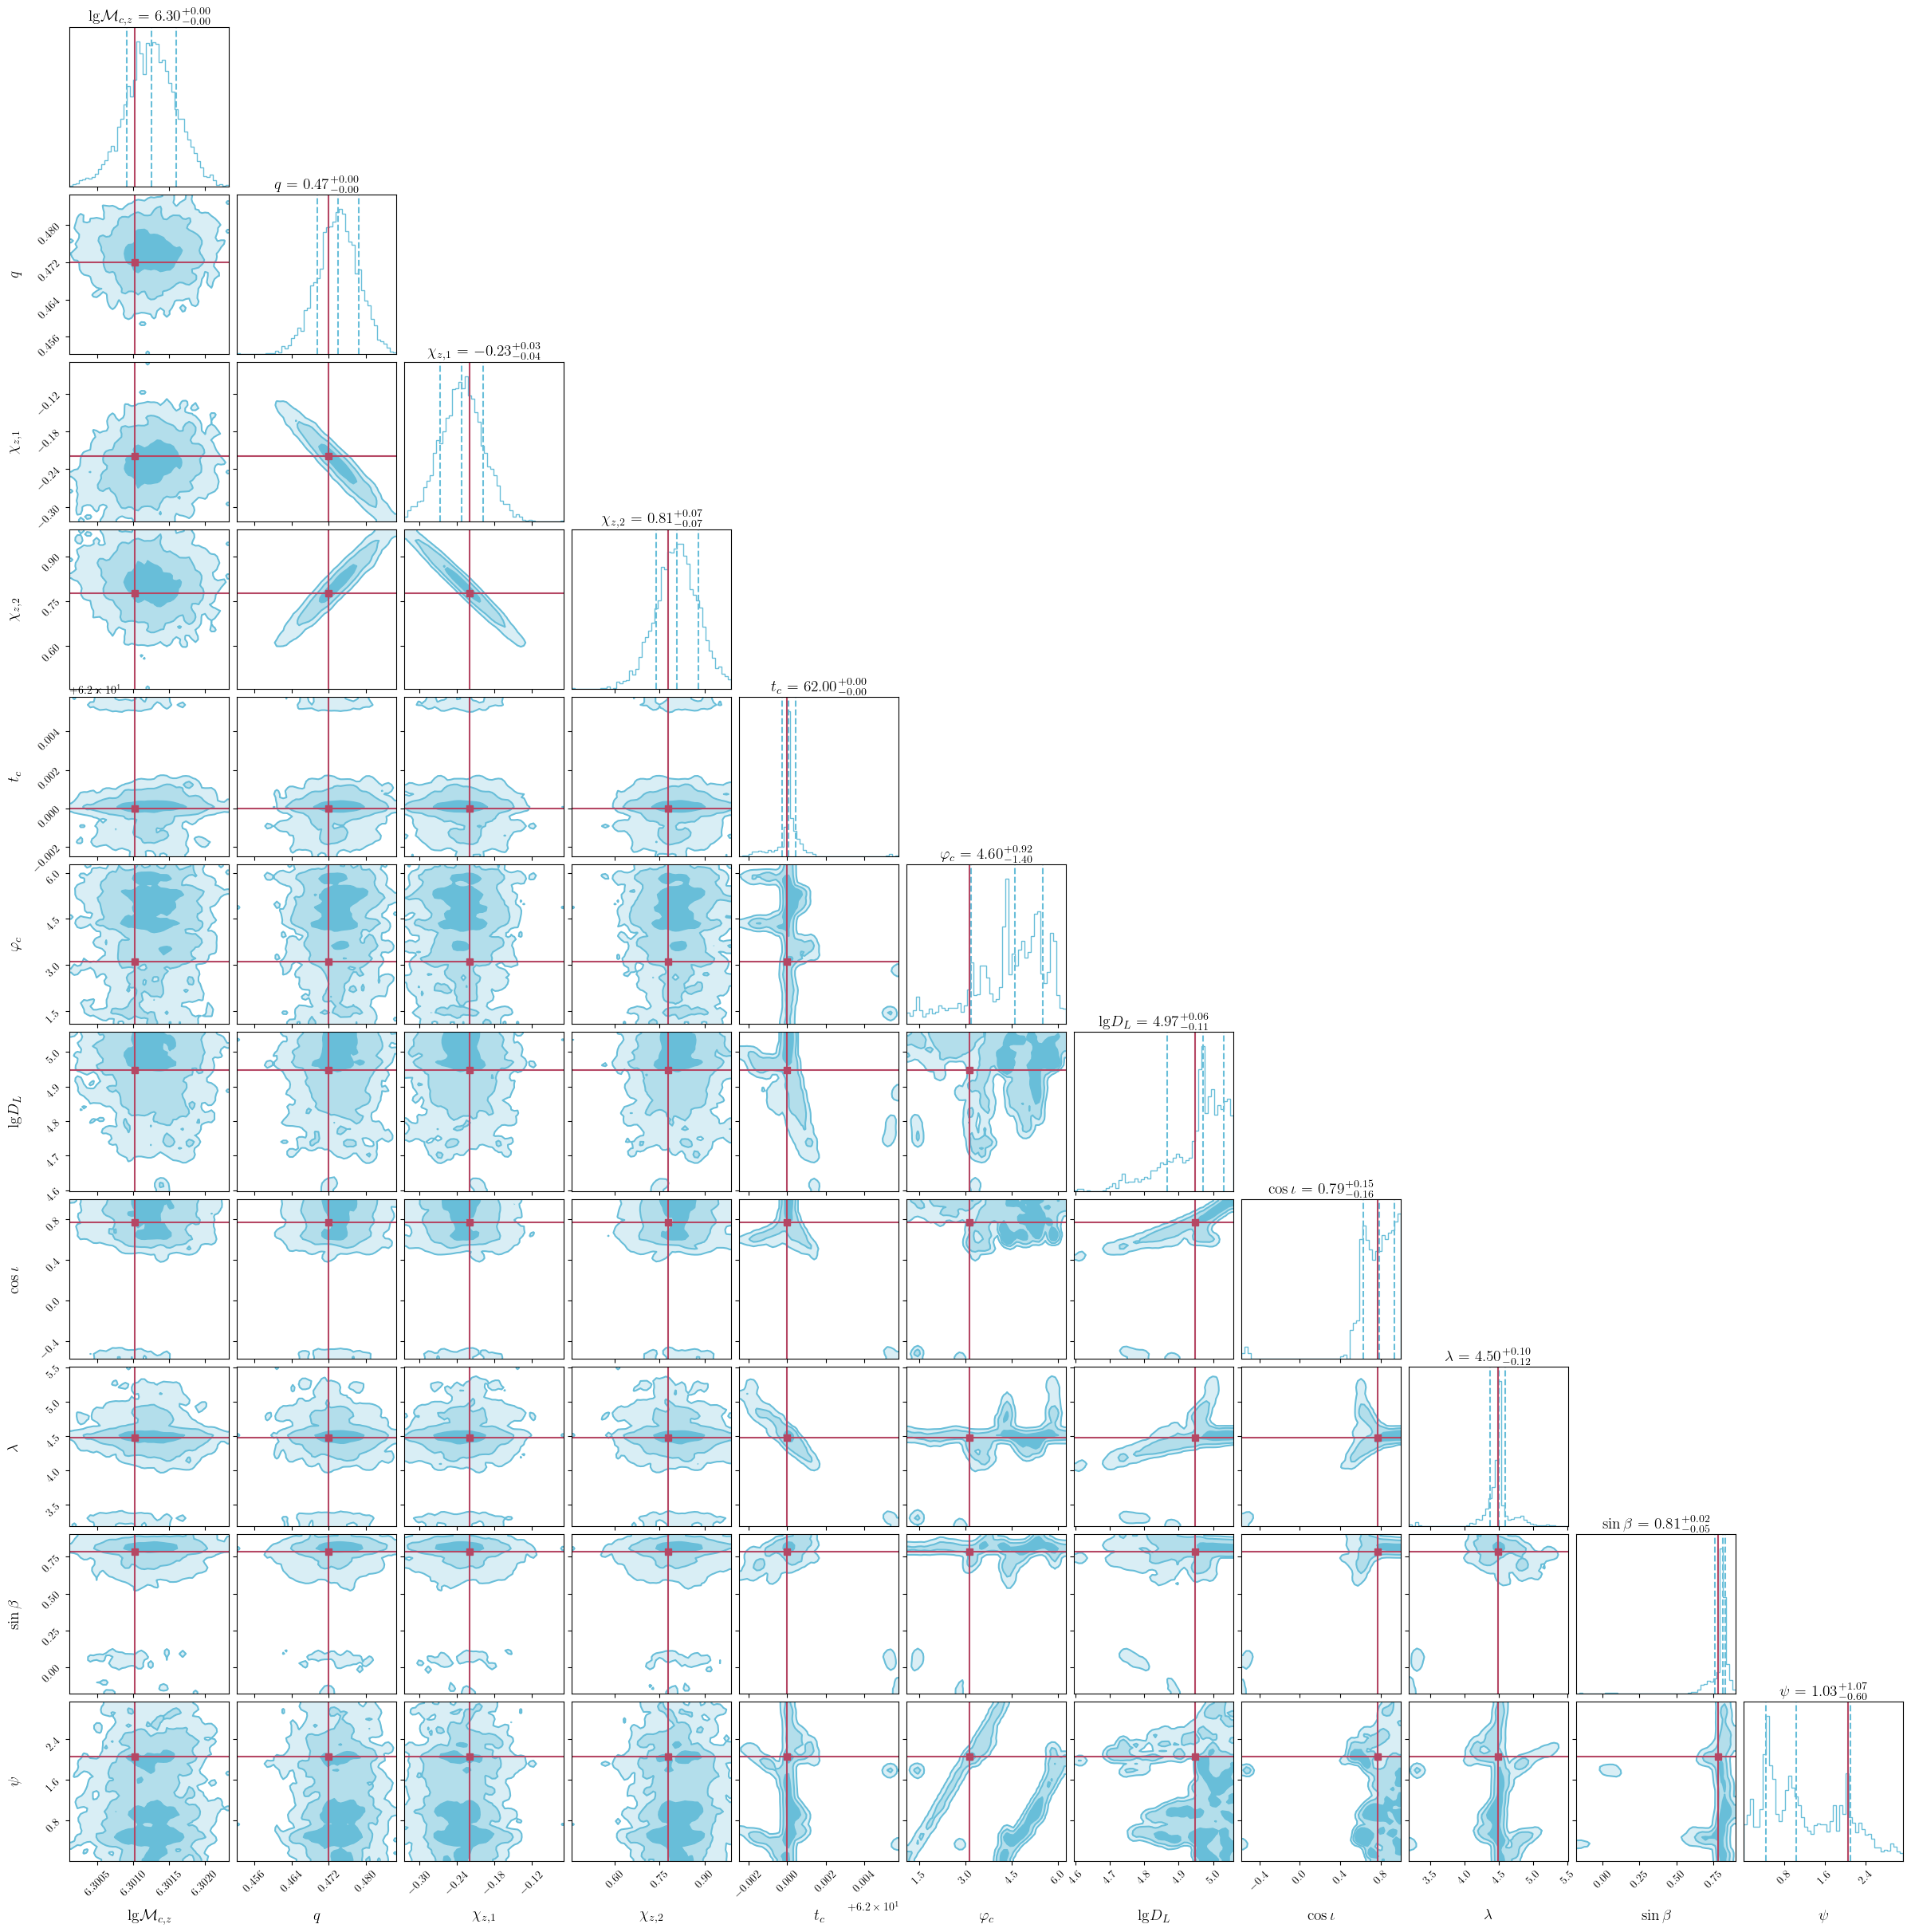

In [ ]:
burnin=1000
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    range=lims,
    truths=truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );